In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.spatial.distance import pdist, squareform
import math
import collections

In [2]:
path = '../fma_metadata/'

tracks = pd.read_csv(path+'tracks.csv', index_col=0, header=[0, 1])
echonest = pd.read_csv(path+'echonest.csv', index_col=0, header=[0, 1, 2])

# Features selected and extracted
audio_features = echonest.echonest.audio_features[['acousticness','danceability','instrumentalness']]
genres = tracks.track[['genres', 'genre_top']]
artists_data = echonest.echonest.social_features[['artist_discovery']].copy()\
                /max(echonest.echonest.social_features.artist_discovery) # add a dimension for artists
popularity = tracks.track[['listens']] # to filter by most listened tracks

# Show all the genres of music
features_and_genres = audio_features.merge(genres, left_on='track_id', right_on='track_id', how='inner')\
                                .merge(artists_data, left_on='track_id', right_on='track_id', how='inner')\
                                .merge(popularity, left_on='track_id', right_on='track_id', how='inner')

features_and_genres.genre_top.value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: genre_top, dtype: int64

We keep only the tracks with a minimum of popularity (number of times it was listened to) relatively to each genre.

In [3]:
# Define here how much of the data is cropped:
quantile_listens = 0.3

popu_quantile = features_and_genres[['genre_top', 'listens']].groupby(by='genre_top')\
                    .quantile([quantile_listens])\
                    .reset_index()[['genre_top', 'listens']].rename(columns = {'listens':'threshold'})
temp = pd.merge(features_and_genres.reset_index(), popu_quantile, left_on='genre_top', right_on='genre_top', how='inner')\
         .set_index('track_id')
features_reduced = temp[temp.listens > temp.threshold].drop(columns=['listens','threshold'])
features_reduced.genre_top.value_counts()

Rock                   2721
Electronic             1519
Hip-Hop                 636
Folk                    611
Old-Time / Historic     250
Pop                     242
Classical               185
Jazz                    168
International            93
Instrumental             59
Blues                    46
Experimental             12
Name: genre_top, dtype: int64

Comparison between how many tracks we have left compared to before:

In [4]:
features_reduced.genre_top.describe()

count     6542
unique      12
top       Rock
freq      2721
Name: genre_top, dtype: object

In [5]:
features_and_genres.genre_top.describe()

count     9355
unique      12
top       Rock
freq      3892
Name: genre_top, dtype: object

In [6]:
# Select the genres that you want in your graph 
# Add them in the "selected genres" down below

selected_genres = ['Pop', 'Classical', 'Jazz', 'International']

features = features_reduced[features_reduced.genre_top.isin(selected_genres)]

features = features.drop(columns=['genres','genre_top'])
# keep only numerical data now that the selection according to genres is done
features.head()

,acousticness,danceability,instrumentalness,artist_discovery
track_id,,,,
10,0.951670,0.658179,0.965427,0.834591
213,0.933741,0.312720,0.919242,0.693935
821,0.400494,0.862510,0.908926,0.596074
822,0.674356,0.870449,0.886045,0.596074
1051,0.976734,0.294640,0.889793,0.363704


In [7]:
distances = pdist(features.values, metric='euclidean')
# weights computed with a kernel and removing all the weights below threshold
threshold = 0.6

# Gaussian kernel: 
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
weights[weights < threshold] = 0
adjacency = squareform(weights)# the adjacency matrix
n_nodes = len(features)

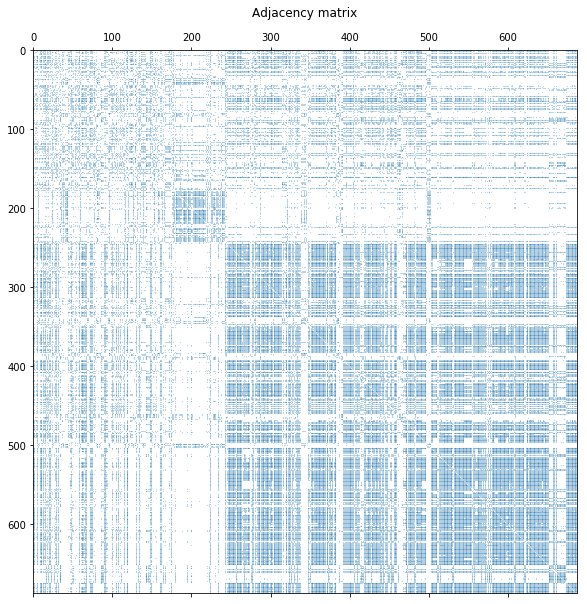

In [8]:
figure1 = plt.figure(figsize=(10, 10))
plt.spy(adjacency, markersize=0.08, figure = figure1)
plt.title('Adjacency matrix')
plt.show()

In [9]:
features.to_csv('out_features.csv')
np.save('adjacency', adjacency)